In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.io import imread_collection
from pathlib import Path
import itertools
import cv2


%matplotlib inline

/Users/kasey/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Deep Drink
Using image inpainting to censor images of alcoholic beverages.

## Pre-processing: Loading Data

In [4]:
num_px = 128

In [5]:
# Load images from the local images folder
# Images downloaded from Open Images using 
# https://github.com/EscVM/OIDv4_ToolKit
def load_images():
    img_dir = 'images/Beer/*.jpg'
    img_col = imread_collection(img_dir)
    final_col = []
    img_files = [x.replace("images/Beer/", "")[:-4] for x in img_col.files]
    for (img, fn) in zip(img_col, img_files):
        img = img/255.
        #img_resize = resize(img, output_shape=(num_px, num_px), mode='constant')
        final_col.append((fn, img))
    return final_col

In [6]:
# Load labels from local labels folder
# Labels downloaded from Open Images using 
# https://github.com/EscVM/OIDv4_ToolKit
def load_labels_dict():
    my_dir = Path('images/Beer/Label/')
    d = {}
    
    for file in my_dir.glob('*.txt'):
        line = file.read_text(encoding='utf-8').split()
        
        for i in range(0, len(line), 5): 
            # label, x-coordinate, y-coordinate, width, height
            (label, x, y, w, h) = line[i:i+5]
            filename = file.stem

            if (file.stem in d):
                d[file.stem].append({'coordinates': {'x': x, 'y': y, 'width': w, 'height': h}})
            else:
                d[file.stem] = [{'coordinates': {'x': x, 'y': y, 'width': w, 'height': h}}] 
    return d

In [7]:
labels = load_labels_dict()

In [8]:
# Load images into a collection
images = load_images()

[{'coordinates': {'x': '528.08704', 'y': '473.08552199999997', 'width': '747.890688', 'height': '819.0'}}]


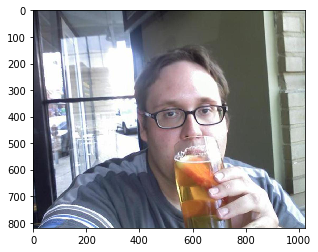

In [9]:
# Example of a picture
index = 2
plt.imshow(images[index][1])
print(labels[images[index][0]])

## Object Detection with YOLO
The following section was adapted from https://www.arunponnusamy.com/yolo-object-detection-opencv-python.html.


In [12]:
# Adapted from https://www.arunponnusamy.com/yolo-object-detection-opencv-python.html

pretrained_weights = 'yolov3.weights'
config_file = 'yolov3.cfg'
classes_raw = 'yolov3.txt'
image = cv2.imread('images/Beer/1aa3acb3e0b57865.jpg')

Width = image.shape[1]
Height = image.shape[0]
scale = 0.005

# read class names from text file
classes = None
with open(classes_raw, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# generate different colors for different classes 
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

# read pre-trained model and config file
net = cv2.dnn.readNet(pretrained_weights, config_file)

# create input blob 
blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

# set input blob for the network
net.setInput(blob)


error: OpenCV(4.1.1) /Users/travis/build/skvark/opencv-python/opencv/modules/dnn/src/darknet/darknet_importer.cpp:214: error: (-212:Parsing error) Failed to parse NetParameter file: yolov3.weights in function 'readNetFromDarknet'
